### Notebook com explição dos códigos
#### Aluno: Thiago Rodrigues Cruz Justino
#### Professores: Giberto Farias e Bruno Jefferson de Sousa
Os arquivos train.csv e test.csv contêm imagens do dataset MNIST, em escala de cinza, dos
dígitos 0, 1, 4 e 5 escritos a mão. Cada imagem é composta por 28 linhas e 28 colunas em um
total de 784 pixels. Cada pixel possui um valor associado único, que indica seu tom de cinza.
Quanto mais alto é esse valor, mais escuro é o pixel. Os valores de cada pixel estão no intervalo
fechado [0, 255].


Os dados de entrada, (train.csv), possuem 785 colunas. A primeira coluna, chamada “label”,
é o dígito que foi desenhado pelo usuário. O resto das colunas contém os valores dos pixels da
imagem associada.


Cada coluna de pixel, nos dados de treino, é nomeada como “pixel𝑥”, onde 𝑥 é um inteiro
no intervalo [0, 783]. Para localizar este pixel na imagem, suponha que decompomos 𝑥 como
𝑥 = 𝑖 ∗ 28 + 𝑗, onde 𝑖 e 𝑗 são inteiros no intervalor [0, 27]. Então o “pixel𝑥” está localizado na
linha 𝑖 e coluna 𝑗 de uma matriz 28𝑥28 (indexada por zero). Por exemplo, “pixel31” indica o
valor do pixel que está na quarta coluna, da esquerda pra direita, e na segunda linha.
Os dados de teste, (test.csv), possuem o mesmo formato dos dados de treinamento.




#### Bibliotecas usadas:

In [1]:
import pandas as pd
import numpy as np

#### Obtendo dados e visualizando:

In [2]:
path = 'dataset_digits/'
df_test1 = pd.read_csv(f'{path}/test.csv',sep=';')
df_train1 = pd.read_csv(f'{path}/train.csv',sep=';')
df_test1.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Tratamento dos dados e ajustes

Para trabalharmos com modelos de AM que possuem muito pouco grau de liberdade
para a construção de sua função hipótese, devemos diminuir a complexidade dos dados de
entrada através da redução do número de parâmetros 𝑝 das amostras de treinamento.
Como já foi dito na descrição do dataset, cada instância é composta por 𝑝 = 784
parâmetros de entrada, sendo um parâmetro por pixel. Logo, há a necessidade de reduzir a
quantidade de parâmetros total, a fim de atingir bons resultados na classificação das de tais
imagens usando-se modelos de AM mais simples. Uma forma de reduzir consideravelmente
o vetor de características é sintetizar os dados das imagens em apenas duas informações de
entrada (𝑝 = 2) que são muito importantes na identificação de um dígito numérico: a
intensidade e a simetria da imagem.

**Intensidade da imagem**:
Como os pixel mais escuros possuem valores maiores (255 representa o preto), a
intensidade de uma imagem pode ser calculada pela equação:
$$
\frac{\sum_{x=0}^{784} pixelx}{255}
$$




In [4]:
# Função para calcular o somatório dos valores dos pixels divididos por 255
def calculate_pixel_sum(row):
    # Como a primeira coluna é a label e as outras 784 colunas são os valores dos pixels
    pixel_values = row[1:]  # Ignorar a primeira coluna (rótulo)
    return pixel_values.sum() / 255

# Aplicar a função a cada linha do DataFrame
intensidades_test = df_test1.apply(calculate_pixel_sum, axis=1)
intensidades_train = df_train1.apply(calculate_pixel_sum, axis=1)

intensidades_test.head()

0    147.933333
1    131.054902
2    134.890196
3    139.976471
4    129.580392
dtype: float64

**Simetria da imagem**:
A simetria de uma imagem é computada a partir da definição de eixos de simetria.
Existem duas simetrias fáceis de se computar: a vertical e horizontal. Por exemplo, na
simetria vertical dividem-se as colunas da matriz de pixels em duas partes, lado direito e
esquerdo, como ilustrado pelo eixo vertical da Figura 3, e computa-se a diferença dos
valores dos pixels pertencentes as distintas partes.
$$
S_v = \sum_{i=0}^{27} \sum_{j=0}^{13} \frac{\left| p_{i, j} - p_{i, 27 - j} \right|}{255}
$$

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_vertical_symmetry(row):
    """Calcula a simetria vertical para uma linha de pixels de 784 elementos."""
    # Reformate a linha em uma matriz 28x28
    image = row[1:].values.reshape(28, 28)
    
    # Número de colunas na imagem (28)
    num_cols = image.shape[1]
    
    # Calcular a diferença entre pixels simétricos
    symmetry_sum = 0
    for col in range(num_cols):
        symmetry_sum += np.sum(np.abs(image[:, col] - image[:, num_cols - col - 1]))
    
    return symmetry_sum/255

def calculate_horizontal_symmetry(row):
    """Calcula a simetria horizontal para uma linha de pixels de 784 elementos."""
    # Reformate a linha em uma matriz 28x28
    image = row[1:].values.reshape(28, 28)
    
    # Número de linhas na imagem (28)
    num_rows = image.shape[0]
    
    # Calcular a diferença entre pixels simétricos
    symmetry_sum = 0
    for row in range(num_rows):
        symmetry_sum += np.sum(np.abs(image[row, :] - image[num_rows - row - 1, :]))
    
    return symmetry_sum/255

def calculate_total_symmetry(row):
    """Calcula a soma das simetrias vertical e horizontal para uma linha de pixels de 784 elementos."""
    vertical_symmetry = calculate_vertical_symmetry(row)
    horizontal_symmetry = calculate_horizontal_symmetry(row)
    
    return vertical_symmetry + horizontal_symmetry


# Calcular a soma das simetrias vertical e horizontal para cada linha e adicionar como nova coluna
simetrias_test = df_test1.apply(calculate_total_symmetry, axis=1)
simetrias_train = df_train1.apply(calculate_total_symmetry, axis=1)

# Exibir as primeiras linhas do DataFrame atualizado
print(simetrias_test.head())



0    260.941176
1    245.443137
2    303.450980
3    267.843137
4    260.549020
dtype: float64


#### Concatenando as informações:

In [9]:
df_teste = pd.concat([df_test1['label'],intensidades_test,simetrias_test],axis=1)
df_train = pd.concat([df_train1['label'],intensidades_train,simetrias_train],axis=1)
df_teste.columns = ['label','intensidade','simetria']
df_train.columns = ['label','intensidade','simetria']
df_teste.head()

,label,intensidade,simetria
0,0,147.933333,260.941176
1,0,131.054902,245.443137
2,0,134.890196,303.450980
3,0,139.976471,267.843137
4,0,129.580392,260.549020


#### Extra: função para visualizar a imagem caso seja necessário

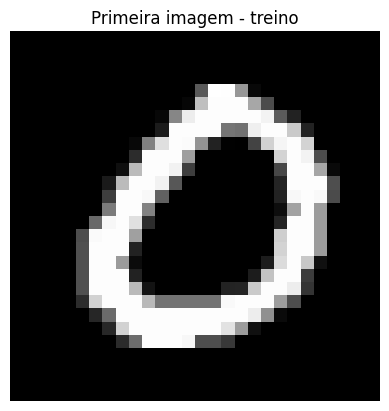

In [10]:
def plot(row,title=False):
    """Plota a imagem a partir de uma linha de pixels de 784 elementos."""
    # Reformate a linha em uma matriz 28x28
    image = row[1:].values.reshape(28, 28)
    
    # Plota a imagem
    plt.imshow(image, cmap='gray')
    if title:   plt.title(f'{title}')
    plt.axis('off')  # Desliga os eixos
    plt.show()

plot(df_train1.iloc[0],'Primeira imagem - treino')

#### Visualizando o gráfico com os pontos (intensidade,simetria) de cada label

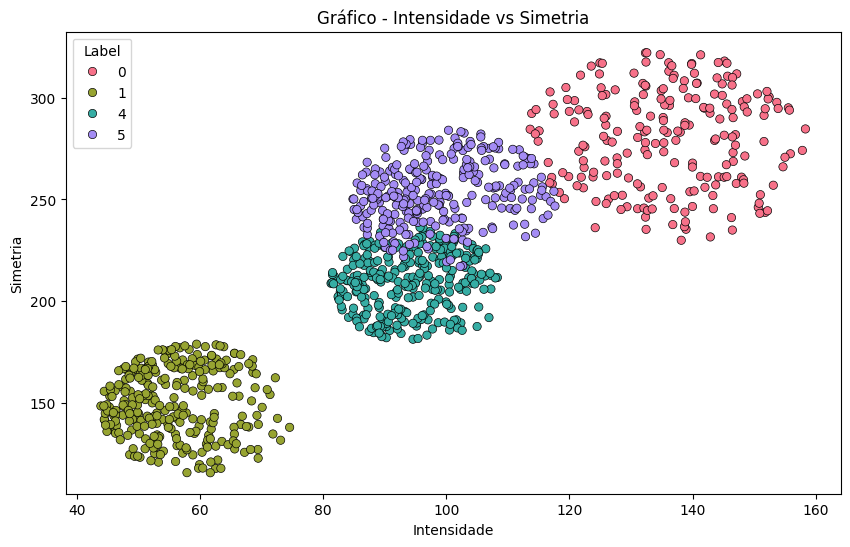

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_teste já está configurado corretamente com colunas 'label', 'intensidades', e 'simetrias'
# Aqui assumimos que 'intensidades' e 'simetrias' são colunas numéricas

# Criar uma paleta de cores discreta para os labels
unique_labels = df_teste['label'].unique()
palette = sns.color_palette("husl", len(unique_labels))  # Usa a paleta de cores Husl com uma cor para cada label

# Criar o gráfico usando seaborn
plt.figure(figsize=(10, 6))

# Plotar Intensidade vs. Simetria
sns.scatterplot(x='intensidade', y='simetria', hue='label', data=df_teste, palette=palette, edgecolor='k')

# Adicionar título e rótulos
plt.title('Gráfico - Intensidade vs Simetria')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.legend(title='Label')
plt.savefig('imagens/grafico_int_simetria.png')
plt.show()

